In [50]:
import pandas as pd

In [51]:
train=pd.read_csv(r"C:\Users\sande\OneDrive\Documents\Priya\Data_science_Dataset\walmart_sales_forecast\train.csv",na_values=["NA","null"])
test=pd.read_csv(r"C:\Users\sande\OneDrive\Documents\Priya\Data_science_Dataset\walmart_sales_forecast\test.csv",na_values=["NA","null"])
features=pd.read_csv(r"C:\Users\sande\OneDrive\Documents\Priya\Data_science_Dataset\walmart_sales_forecast\features.csv",na_values=["NA","null"])
stores=pd.read_csv(r"C:\Users\sande\OneDrive\Documents\Priya\Data_science_Dataset\walmart_sales_forecast\stores.csv",na_values=["NA","null"])

In [52]:
train=train.merge(features,on=["Store","Date"],how="left")
train=train.merge(stores,on=["Store"],how="left")

In [53]:
test=test.merge(features,on=["Store","Date"],how="left")
test=test.merge(stores,on=["Store"],how="left")

In [54]:
(train['IsHoliday_x']==train['IsHoliday_y']).all()
train=train.drop('IsHoliday_x',axis=1)


In [55]:
train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday_y', 'Type', 'Size'],
      dtype='object')

In [56]:
print((test['IsHoliday_x']==test['IsHoliday_y']).all())
test=test.drop('IsHoliday_x',axis=1)

True


In [8]:
train[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].isna().sum()

MarkDown1    270889
MarkDown2    310322
MarkDown3    284479
MarkDown4    286603
MarkDown5    270138
dtype: int64

In [57]:
md_cols=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

train[md_cols]=train[md_cols].fillna(0)
test[md_cols]=test[md_cols].fillna(0)

In [25]:
train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday_y', 'Type', 'Size'],
      dtype='object')

In [11]:
train[['Size']].isna().sum()

Size    0
dtype: int64

In [12]:
train.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday_y     0
Type            0
Size            0
dtype: int64

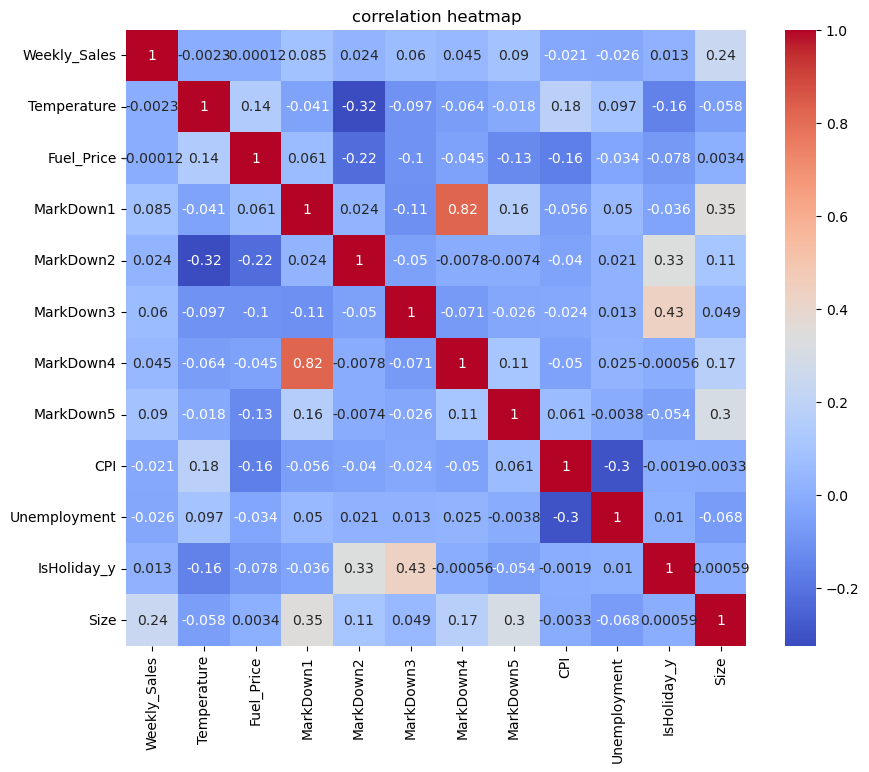

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

train_1=train.drop(['Date','Store','Dept','Type'],axis=1)
corr=train_1.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.title("correlation heatmap")
plt.show()

In [8]:
train.shape

(421570, 16)

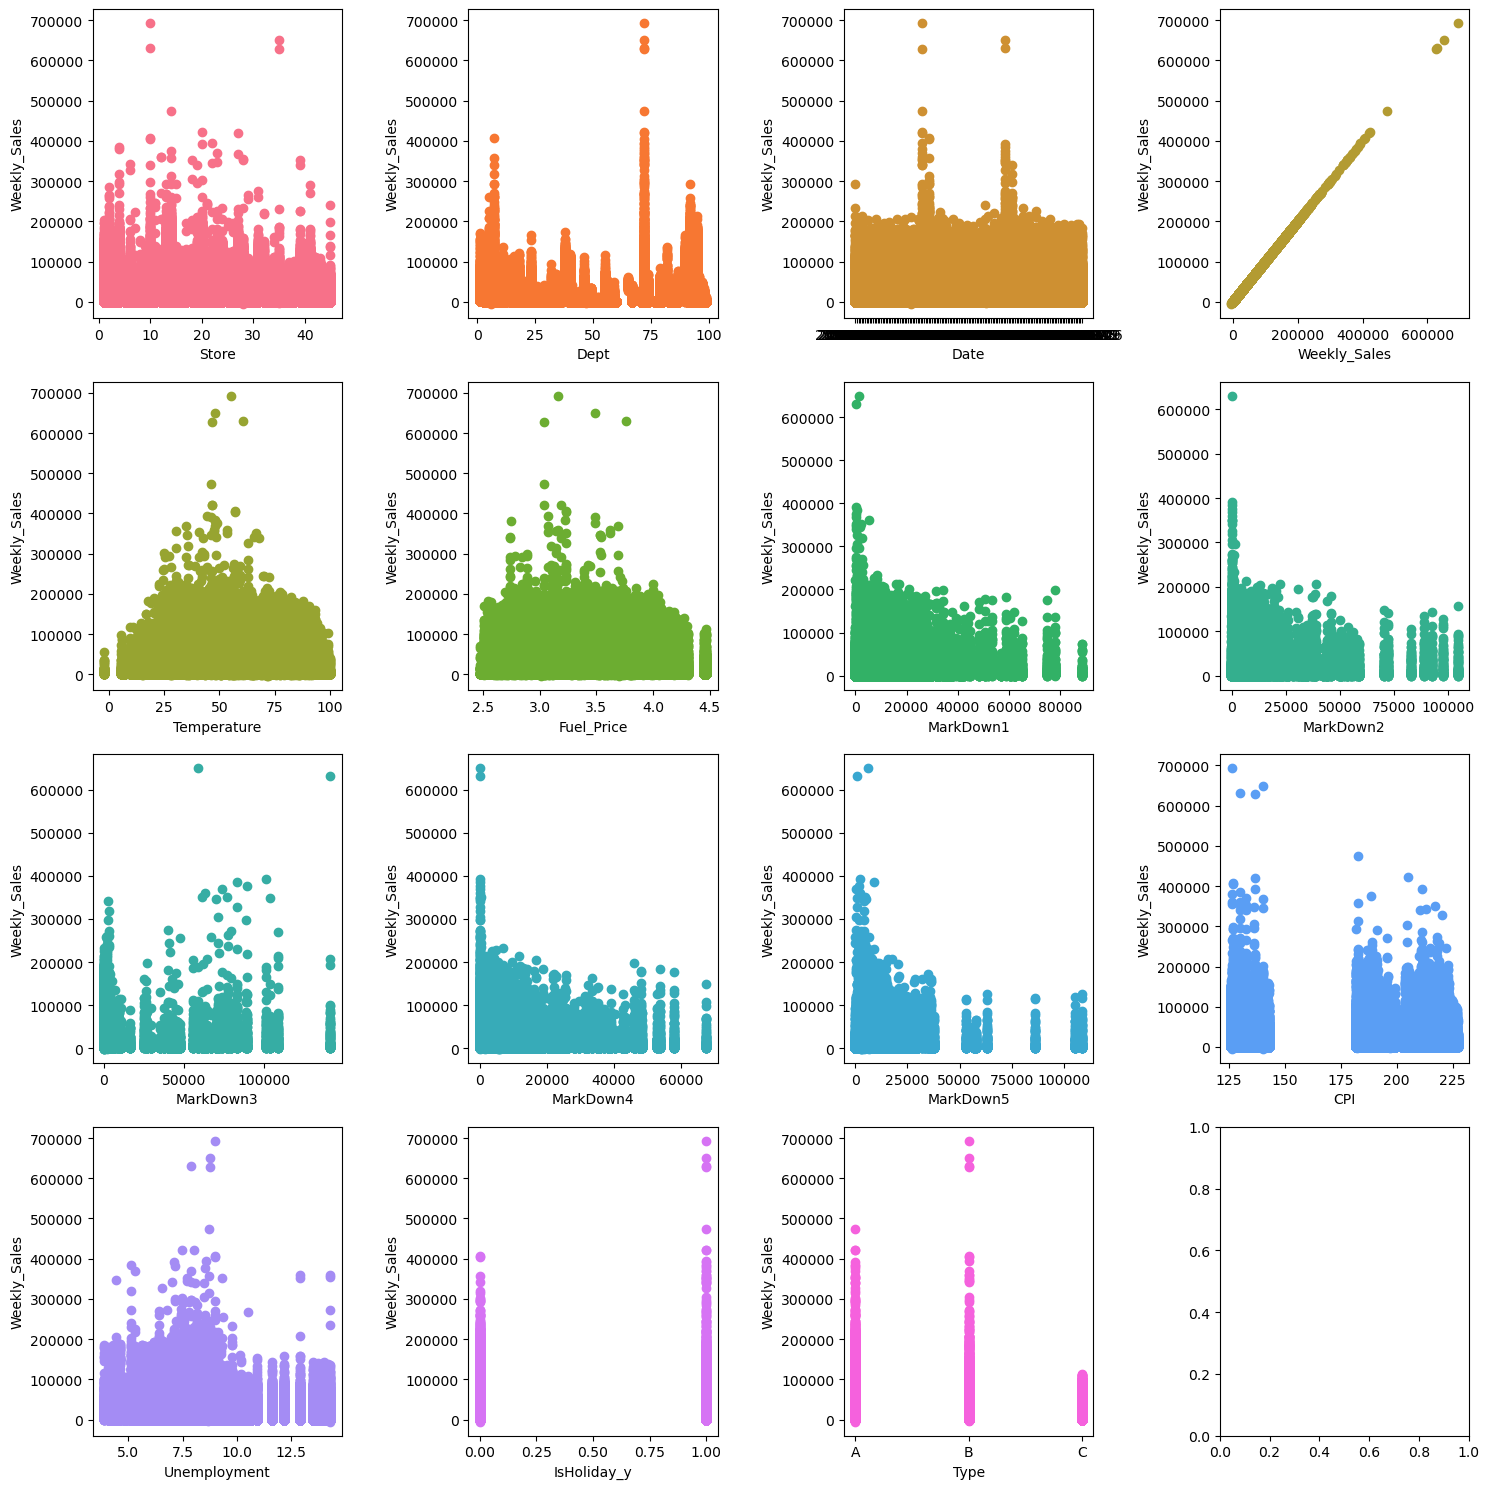

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig,axes = plt.subplots(4,4,figsize=(15,15)) #5*3=15 plots
axes = axes.flatten() #convert 2D to 1D , 15 axes objects

features = train.columns[:-1] #all columns except  MEDV
colors =sns.color_palette("husl",n_colors=16)

for i,feature in enumerate(features):
    axes[i].scatter(train[feature],train["Weekly_Sales"],color=colors[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Weekly_Sales")

plt.tight_layout()
plt.show()



In [58]:
#Convert date to datetime
train['Date']=pd.to_datetime(train['Date'])

#Extract date based features
train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Week']=train['Date'].dt.isocalendar().week
train['DateofWeek']=train['Date'].dt.weekday

#Sort BEFORE creaing lag features
train=train.sort_values(['Store','Dept','Date'])

#Creating lag features based on Store, Dept so that lags are within the same store and department, not mixed with other stores.
train["lag_1"]=train.groupby(["Store","Dept"])["Weekly_Sales"].shift(1) #Last week
train["lag_4"]=train.groupby(["Store","Dept"])["Weekly_Sales"].shift(4) # Monthly trend(4 weeks ago)
train["lag_13"]=train.groupby(["Store","Dept"])["Weekly_Sales"].shift(13) # Quarterly trend
train["lag_52"]=train.groupby(["Store","Dept"])["Weekly_Sales"].shift(52) #Same week last year


train=train.dropna()

In [68]:
#Checking correlations of lag_features with weekly_Sales
print("Lag_1",train["Weekly_Sales"].corr(train["lag_1"]))
print("Lag_4",train["Weekly_Sales"].corr(train["lag_4"]))
print("Lag_13",train["Weekly_Sales"].corr(train["lag_13"]))
print("Lag_52",train["Weekly_Sales"].corr(train["lag_52"]))

Lag_1 0.9599734882363392
Lag_4 0.9472835920155902
Lag_13 0.8988153301226504
Lag_52 0.9809197540986986


In [61]:
#Applying one hot encoding for categorical features
categorical_cols=['Store','Dept','Type']

train=pd.get_dummies(train,columns=categorical_cols)
test=pd.get_dummies(test,columns=categorical_cols)

#align train and test columns(important if some categories only exist in one set
train,test=train.align(test,join='left',axis=1,fill_value=0)

In [60]:
train['Date'].max

<bound method Series.max of 52       2011-02-04
53       2011-02-11
54       2011-02-18
55       2011-02-25
56       2011-03-04
            ...    
421565   2012-09-28
421566   2012-10-05
421567   2012-10-12
421568   2012-10-19
421569   2012-10-26
Name: Date, Length: 261083, dtype: datetime64[ns]>

In [24]:
train.shape

(95214, 23)

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
import numpy as np
from xgboost import XGBRegressor





In [74]:
train_split=train[train['Date']<"2012-01-01"]
test_split=train[train["Date"]<"2012-01-01"]

X_train=train_split.drop(["Weekly_Sales","Date"],axis=1)
Y_train=train_split["Weekly_Sales"]

X_test=test_split.drop(["Weekly_Sales","Date"],axis=1)
Y_test=test_split["Weekly_Sales"]

print("Training started")
model=XGBRegressor(n_estimators=1000,learning_rate=0.01,random_state=42,tree_method='hist')
model.fit(X_train,Y_train)

#Evaluation

#Average weekly sales of test data
Average_Weekly_Sales= Y_test.mean()
print("Average Weekly Sales=",Average_Weekly_Sales)

Y_test_pred = model.predict(X_test)
Y_train_pred=model.predict(X_train)

test_r2 = r2_score(Y_test,Y_test_pred)
print("Test_r2=",test_r2)

train_r2=r2_score(Y_train,Y_train_pred)
print("Train r2=",train_r2)

mae=mean_absolute_error(Y_test,Y_test_pred)
print("mae:",mae)
print("MAE based relative error", mae/Average_Weekly_Sales)

mse = mean_squared_error(Y_test,Y_test_pred)
print("mse=",mse)

rmse=np.sqrt(mse)
print("rmse=",rmse)

rmse=np.sqrt(mse)
print("rmse=:",rmse)
print("RMSE based relative error", rmse/Average_Weekly_Sales)


Training started
Average Weekly Sales= 16729.24308870341
Test_r2= 0.988249834394383
Train r2= 0.988249834394383
mae: 1267.0615101925455
MAE based relative error 0.07573932086910384
mse= 6353386.818086686
rmse= 2520.5925529697747
rmse=: 2520.5925529697747
RMSE based relative error 0.15066985036949043


In [73]:
train_split=train[train['Date']<"2012-01-01"]
test_split=train[train["Date"]<"2012-01-01"]

X_train=train_split.drop(["Weekly_Sales","Date"],axis=1)
Y_train=train_split["Weekly_Sales"]

X_test=test_split.drop(["Weekly_Sales","Date"],axis=1)
Y_test=test_split["Weekly_Sales"]

print("Training started")
model=RandomForestRegressor(n_estimators=50,random_state=42,n_jobs=-1)
model.fit(X_train,Y_train)

#Evaluation

#Average weekly sales of test data
Average_Weekly_Sales= Y_test.mean()
print("Average Weekly Sales=",Average_Weekly_Sales)

Y_test_pred = model.predict(X_test)
Y_train_pred=model.predict(X_train)

test_r2 = r2_score(Y_test,Y_test_pred)
print("Test_r2=",test_r2)

train_r2=r2_score(Y_train,Y_train_pred)
print("Train r2=",train_r2)

mae=mean_absolute_error(Y_test,Y_test_pred)
print("mae:",mae)
print("MAE based relative error", mae/Average_Weekly_Sales)

mse = mean_squared_error(Y_test,Y_test_pred)
print("mse=",mse)

rmse=np.sqrt(mse)
print("rmse=",rmse)

rmse=np.sqrt(mse)
print("rmse=:",rmse)
print("RMSE based relative error", rmse/Average_Weekly_Sales)



Training started
Average Weekly Sales= 16729.24308870341
Test_r2= 0.9975851425527948
Train r2= 0.9975851425527948
mae: 502.68551610802257
MAE based relative error 0.03004831201523194
mse= 1305728.2754633878
rmse= 1142.6846789308886
rmse=: 1142.6846789308886
RMSE based relative error 0.06830462519266625
